In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys, os
sys.path.append("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")
os.chdir("C:/Users/lheindrich/Documents/Scalable-discovery/metacontroller/")

from utils.distributions import Categorical

In [2]:
path = os.getcwd() + "/pilot2-data/dataclips_gsadjtxispeszxuoenyomeqebpch.json"

data = json.load(open(path))

high_risk_clicks = [8, 23, 38, 53]
COST = 10
high_risk_click_reward = -1500 * 0.1
meta_expected_scores = [65, 45, 60, 45, 60]
hierarchical_expected_scores =  [75, 55, -1460, 55, 70]

In [3]:
def get_expected_score(trialdata, COST=COST):
    path = trialdata["path"]
    queries = trialdata["queries"]["click"]["state"]["target"]
    # Replace first element with 0 for root
    ground_truth =  [0] + trialdata["stateRewards"][1:]
    reward = 0
    #print(path)
    #print(high_risk_clicks)
    for node in path:
        if node in queries:
            reward += ground_truth[int(node)]
        else:
            if (node in high_risk_clicks) or (int(node) in high_risk_clicks):
                reward += high_risk_click_reward #Probability of triggering high risk event * negative reward of high risk event
            else:
                reward += 0 # Depends on experiment, in this case the expectation of all other nodes is 0
    # Click cost
    reward -= len(queries) * COST
    return reward

In [4]:
df_index = ["Participant", "Condition", "TrialId", "Score", "ExpectedScore", "NumClicks", "TestEnv", "HighRiskClicks"]
df_data = []

bonus_data = {}
known_workers = []
good_responses = 0

# Parse raw mturk data into dataframe
for p_index, p_data in enumerate(data["values"]):
    # Filter out empty responses
    response_data = p_data[-1]
    if response_data != None:
        p_res_obj = json.loads(response_data)
        condition = p_res_obj["condition"]
        # Obfuscate worker ID for publishing
        worker = p_index #p_res_obj["workerId"]
        if worker in known_workers:
            print("Duplicate worker", worker)
        else: 
            known_workers.append(worker)
        p_res = p_res_obj["data"]
        # Filter our incomplete trials
        # Get last instruction index
        # Test trials start after the last instruction
        # Index of that in the experiment is variable due to repeated instructions/quiz
        instruction_index = 0
        for i in range(len(p_res)):
            #print(p_res[i]["trialdata"]["trial_type"])
            if p_res[i]["trialdata"]["trial_type"] == "instructions":
                instruction_index = i+1
        #print(instruction_index)
        if len(p_res) > instruction_index + 5:
            good_responses += 1
            for i in range(instruction_index,instruction_index+5):
                trial = p_res[i]
                trialdata = trial["trialdata"]
                assert trialdata["trial_type"] == "mouselab-mdp"
                trialid = trialdata["trial_id"]
                queries = trialdata["queries"]["click"]["state"]["target"]
                path = trialdata["path"]
                score = trialdata["score"]
                trial_id = int(trialdata["trial_id"])
                expected_score = get_expected_score(trialdata)
                num_risk_clicks = sum([1 for el in high_risk_clicks if str(el) in queries])
                df_data.append([worker, condition, trialid, score, expected_score, len(queries), trial_id, num_risk_clicks])
        try:
            bonus_data[worker] = p_res_obj["questiondata"]["final_bonus"]
        except:
            pass
            #print("Uncompleted but usable trial for worker", worker)

print("Good responses", good_responses)
df = pd.DataFrame(df_data, columns=df_index)

Good responses 87


In [5]:
# Exclude participants with 0 clicks
participants = pd.DataFrame(df[df["NumClicks"] == 0].groupby("Participant").count()["NumClicks"])
excluded = list(participants[participants["NumClicks"]>2].index)
print("Exlcuded participants", excluded)

Exlcuded participants [2, 4, 5, 19, 38, 40, 47, 55, 64, 68, 71, 99, 110, 111, 117, 121]


In [6]:
df_after_exclusion = df[~df["Participant"].isin(excluded)]
df_after_exclusion.to_csv(os.getcwd() + "/main_excluded.csv")
len(df_after_exclusion)

355

In [7]:
print("Total", len(df_after_exclusion["Participant"].unique()))
df_after_exclusion.groupby(["Condition", "Participant"]).count()["TrialId"].reset_index().groupby("Condition").count()

Total 71


,Participant,TrialId
Condition,,
0,20,20
1,25,25
2,26,26


In [8]:
print("Average bonus:", np.round(np.mean(list(bonus_data.values())),2))
print("Minimum bonus:", np.round(np.min(list(bonus_data.values())),2))
print("Maximum bonus:", np.round(np.max(list(bonus_data.values())),2))
print("Summed bonues", np.sum(list(bonus_data.values())))
print("\n")
for participant, bonus in bonus_data.items():
    if bonus > 0:
        print(f"{participant}, {bonus}")

Average bonus: 0.19
Minimum bonus: 0.0
Maximum bonus: 1.0
Summed bonues 16.740000000000002


2, 1
3, 1
5, 1
9, 0.96
15, 0.24
32, 0.89
42, 0.91
45, 0.64
54, 0.93
55, 0.89
61, 0.76
64, 0.4
65, 0.11
85, 0.6
89, 0.89
96, 1
97, 1
101, 0.47
110, 1
117, 1
120, 0.38
123, 0.67


### Basic statistics of the data (rest in R)

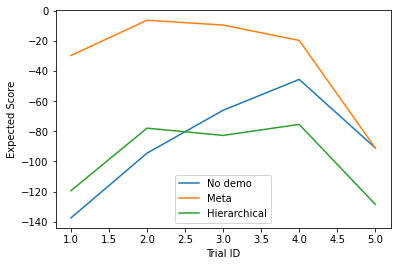

In [9]:
# Plot of scores per condition

score_per_trial = df_after_exclusion.groupby(["Condition", "TrialId"]).mean()[["Score", "ExpectedScore"]]
score_per_trial = score_per_trial.reset_index()


plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==0], label="No demo")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==1], label="Meta")
plt.plot("TrialId", "ExpectedScore", data=score_per_trial[score_per_trial["Condition"]==2], label="Hierarchical")
plt.xlabel("Trial ID")
plt.ylabel("Expected Score")
plt.legend()

In [10]:
df_after_exclusion.groupby("Condition").mean()[["ExpectedScore", "HighRiskClicks", "NumClicks"]]

,ExpectedScore,HighRiskClicks,NumClicks
Condition,,,
0,-86.900000,1.190000,6.630000
1,-31.160000,1.080000,4.080000
2,-96.769231,0.253846,3.061538


In [11]:
df_after_exclusion.groupby("Condition").std()["ExpectedScore"]

Condition
0    73.198154
1    83.199953
2    57.228840
Name: ExpectedScore, dtype: float64

In [12]:
df_after_exclusion.groupby(["Condition", "TrialId"]).mean()["Score"]

Condition  TrialId
0          1         -479.750000
           2         -147.250000
           3         -188.250000
           4           28.750000
           5         -551.250000
1          1          -49.200000
           2           53.800000
           3         -124.200000
           4           54.400000
           5         -721.400000
2          1          -39.230769
           2           -0.192308
           3         -516.538462
           4           60.961538
           5         -906.153846
Name: Score, dtype: float64

In [13]:
# Compare actual scores on trial 3
trial3 = df_after_exclusion[df_after_exclusion["TrialId"] == 3]

c1 = list(trial3[trial3["Condition"] == 1]["Score"])
c2 = list(trial3[trial3["Condition"] == 2]["Score"])

from scipy import stats

stats.ranksums(c1,c2)

RanksumsResult(statistic=0.19784340230171824, pvalue=0.8431675871549421)

In [14]:
print(np.mean(c1), np.std(c1))

print(np.mean(c2), np.std(c2))

print(np.std(c1+c2))

-124.2 496.533342284282
-516.5384615384615 750.1496892041066
667.9837767704022
